
# CISCO data with VAE

This notebook runs VAE model on the open access CISCO dataset.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import torch
import math

# VAE is in other folder as well as opacus adapted library
import sys

sys.path.append("../")

# Opacus support for differential privacy
from opacus.utils.uniform_sampler import UniformWithReplacementSampler

# For the SUPPORT dataset
from pycox.datasets import support

# For VAE dataset formatting
from torch.utils.data import TensorDataset, DataLoader

# VAE functions
from VAE import Decoder, Encoder, VAE

# Utility file contains all functions required to run notebook
from utils import (
    set_seed,
    mimic_pre_proc,
    plot_elbo,
    plot_likelihood_breakdown,
    plot_variable_distributions,
    reverse_transformers,
)
from metrics import distribution_metrics, privacy_metrics

import warnings
warnings.filterwarnings("ignore")  
# We suppress warnings to avoid SDMETRICS throwing unique synthetic data warnings (i.e.
# data in synthetic set is not in the real data set) as well as SKLEARN throwing convergence warnings (pre-processing uses
# GMM from sklearn and this throws non convergence warnings)


## Data Loading & Column Definitions

First we load in the SUPPORT dataset from pycox datasets. Then we define the continuous and categorical columns in that dataset

In [2]:
# load data to pandas dataframe
df = pd.read_csv("data/baseline_no_anomaly_500Gbps.csv")
# Check the type for each column/feature
# df.dtypes

In [3]:
# Cisco data specific, to seperate the entire data based on producer & name groups
print('Unique producers:', df['Producer'].unique())
print('Unique names:', df['name'].unique())

Unique producers: ['leaf4' 'spine1' 'leaf5' 'leaf6' 'dr01' 'leaf3' 'leaf1' 'spine2' 'leaf7'
 'dr02' 'spine4' 'leaf8' 'leaf2' 'spine3' 'dr03']
Unique names: ['Cisco-IOS-XR-fib-common-oper:fib-statistics/nodes/node/drops'
 'Cisco-IOS-XR-infra-statsd-oper:infra-statistics/interfaces/interface/latest/data-rate'
 'Cisco-IOS-XR-infra-statsd-oper:infra-statistics/interfaces/interface/latest/generic-counters'
 'Cisco-IOS-XR-ip-rib-ipv4-oper:rib/vrfs/vrf/afs/af/safs/saf/ip-rib-route-table-names/ip-rib-route-table-name/protocol/bgp/as/information'
 'Cisco-IOS-XR-ipv4-bgp-oper:bgp/instances/instance/instance-active/default-vrf/process-info'
 'Cisco-IOS-XR-nto-misc-oper:memory-summary/nodes/node/summary'
 'Cisco-IOS-XR-wdsysmon-fd-oper:system-monitoring/cpu-utilization']


In [4]:
# Define one sub-datset, that name==data-rate, Producer==leaf4
tmp_df = df[(df['name']=='Cisco-IOS-XR-infra-statsd-oper:infra-statistics/interfaces/interface/latest/data-rate') & (df['Producer']=='leaf5')]
# Exclude up the features that we do not need to learn
tmp_df = tmp_df.dropna(axis=1, how='all')
tmp_df = tmp_df.select_dtypes(exclude=['object'])
tmp_df = tmp_df.drop(['time'], axis=1)
input_df = tmp_df.drop(['bandwidth'], axis=1)
# Model input
input_df

,input-data-rate,input-load,input-packet-rate,load-interval,output-data-rate,output-load,output-packet-rate,peak-input-data-rate,peak-input-packet-rate,peak-output-data-rate,peak-output-packet-rate,reliability
15739,2018880.0,5.0,124974.0,0.0,3075568.0,7.0,329097.0,0.0,0.0,0.0,0.0,255.0
15740,3060451.0,7.0,193464.0,0.0,3041142.0,7.0,261292.0,0.0,0.0,0.0,0.0,255.0
15741,1824393.0,4.0,177426.0,0.0,2989099.0,7.0,237856.0,0.0,0.0,0.0,0.0,255.0
15742,2239501.0,5.0,132391.0,0.0,4233590.0,10.0,372600.0,0.0,0.0,0.0,0.0,255.0
15743,3018871.0,7.0,158834.0,0.0,3501113.0,8.0,302182.0,0.0,0.0,0.0,0.0,255.0
...,...,...,...,...,...,...,...,...,...,...,...,...
469218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0
469219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0
469220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0
469221,14164136.0,36.0,1002474.0,0.0,13148083.0,33.0,1093880.0,0.0,0.0,0.0,0.0,255.0


In [5]:
# Find all column/features with categorical value
original_categorical_columns=[]
categorical_len_count=0
for col in input_df:
    if len(input_df[col].unique()) <= 100:
        original_categorical_columns.append(col)
        categorical_len_count += len(input_df[col].unique())
original_categorical_columns

['input-load',
 'load-interval',
 'output-load',
 'peak-input-data-rate',
 'peak-input-packet-rate',
 'peak-output-data-rate',
 'peak-output-packet-rate',
 'reliability']

In [6]:
# The rest column/features are continuous value
original_continuous_columns = list(set(input_df.columns.values.tolist()) - set(original_categorical_columns))
original_continuous_columns

['output-data-rate',
 'input-packet-rate',
 'output-packet-rate',
 'input-data-rate']

## Create noise-added data for training 
Manually add noise for model training.

In [61]:
# Create noise-added data for continous features and categorical features
df_continuous_columns = list(original_continuous_columns)
continuous_df = input_df[df_continuous_columns]

df_categorical_columns = list(original_categorical_columns)
discrete_df = input_df[df_categorical_columns]

continuous_data = continuous_df.to_numpy()
discrete_data = discrete_df.to_numpy()

# Define the original data tensor
continuous_data = torch.tensor(continuous_data)
discrete_data = torch.tensor(discrete_data)


# Add Gaussian noise to continous features
continuous_noisy_data = continuous_data + torch.tensor(np.random.normal(loc=0, scale=0.1, size=continuous_data.shape))

# # Add int noise to categorical features
discrete_noisy_data = discrete_data + torch.tensor(np.random.randint(low=0, high=1.0, size=discrete_data.shape))

In [35]:
continuous_df

,output-data-rate,input-packet-rate,output-packet-rate,input-data-rate
15739,3.1e+06,1.2e+05,3.3e+05,2.0e+06
15740,3.0e+06,1.9e+05,2.6e+05,3.1e+06
15741,3.0e+06,1.8e+05,2.4e+05,1.8e+06
15742,4.2e+06,1.3e+05,3.7e+05,2.2e+06
15743,3.5e+06,1.6e+05,3.0e+05,3.0e+06
...,...,...,...,...
469218,0.0e+00,0.0e+00,0.0e+00,0.0e+00
469219,0.0e+00,0.0e+00,0.0e+00,0.0e+00
469220,0.0e+00,0.0e+00,0.0e+00,0.0e+00
469221,1.3e+07,1.0e+06,1.1e+06,1.4e+07


In [36]:
discrete_noisy_df = pd.DataFrame(discrete_noisy_data, columns=df_categorical_columns)
continuous_noisy_df = pd.DataFrame(continuous_noisy_data, columns=df_continuous_columns)

continuous_noisy_df

,output-data-rate,input-packet-rate,output-packet-rate,input-data-rate
0,3.1e+06,1.2e+05,3.3e+05,2.0e+06
1,3.0e+06,1.9e+05,2.6e+05,3.1e+06
2,3.0e+06,1.8e+05,2.4e+05,1.8e+06
3,4.2e+06,1.3e+05,3.7e+05,2.2e+06
4,3.5e+06,1.6e+05,3.0e+05,3.0e+06
...,...,...,...,...
27223,1.1e-01,5.6e-02,1.9e-01,3.3e-02
27224,-1.5e-03,-1.5e-01,3.0e-02,3.2e-02
27225,-1.1e-01,9.7e-02,2.2e-01,-9.7e-03
27226,1.3e+07,1.0e+06,1.1e+06,1.4e+07


In [37]:
noisy_tmp_df = pd.concat([discrete_noisy_df, continuous_noisy_df], axis=1)

## Data Pre-Processing

Data can be pre-processed in 2 ways. Either we use <b>"standard"</b> option which performs a standard scaler on continuous variables - This has known limitations as:

- Data in tables is usually non-gaussian and SynthVAE implements a gaussian loss, so this will perform worse unless the data is KNOWN to follow a gaussian distribution already.

Or we use the second option of <b>"GMM"</b>. This performs a variational gaussian mixture model to scale the data & transform it to a gaussian distribution. We use a maximum number of clusters of 10 but the variational method will select the best number of clusters for that continuous variable. This also has known limitations:

- 10 Clusters is arbitrary and may not be enough for certain variables.
- We are fitting a model to transform the data and hence we are approximating before model is trained. This will lose fidelity as the distribution will not be transformed perfectly.

SUPPORT is a limited dataset as it has no missingness (which our model currently does NOT handle) and it has no datetime columns or other data types. Be wary drawing any conclusions from this set due to these constraints as well as the dataset size. Testing/training new models with this set could be useful but conclusive results should be tested on other sets.

In [38]:
pre_proc_method = "GMM"

(
    input_transformed,
    input_original,
    reordered_dataframe_columns,
    continuous_transformers,
    categorical_transformers,
    num_categories,
    num_continuous,
) = mimic_pre_proc(noisy_tmp_df,
                   original_continuous_columns,
                   original_categorical_columns,
                   pre_proc_method=pre_proc_method)



0 input-load ------index, column
1 load-interval ------index, column
2 output-load ------index, column
3 peak-input-data-rate ------index, column
4 peak-input-packet-rate ------index, column
5 peak-output-data-rate ------index, column
6 peak-output-packet-rate ------index, column
7 reliability ------index, column
8 output-data-rate.component ------index, column
9 input-packet-rate.component ------index, column
10 output-packet-rate.component ------index, column
11 input-data-rate.component ------index, column


In [39]:
from sklearn.model_selection import train_test_split

# Splitting the noise-added transformed data into training and testing sets
X_train, X_test = train_test_split(input_transformed, test_size=0.2, random_state=42)

# Splitting the original df into training and testing sets for later evaluation
original_X_train, original_X_test = train_test_split(input_df, test_size=0.2, random_state=42)


# Printing the shapes of the resulting datasets
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (21782, 73)
Testing data shape: (5446, 73)


In [40]:
num_continuous

4

In [41]:
num_categories

[14, 2, 12, 1, 1, 1, 1, 4, 8, 8, 8, 9]

## Creation & Training of VAE

We can adapt certain parameters of the model e.g. batch size, latent dimension size etc. This model implements early stopping and these values can be adapted.

We can also activate differential privacy by implementing dp-sgd through the opacus library.

In [42]:

# User defined hyperparams
# General training
batch_size = 100
latent_dim = 512
hidden_dim = 1024
n_epochs = 10
logging_freq = 1  # Number of epochs we should log the results to the user
patience = 50  # How many epochs should we allow the model train to see if
# improvement is made
delta = 10  # The difference between elbo values that registers an improvement
filepath = None  # Where to save the best model


# Privacy params
differential_privacy = False  # Do we want to implement differential privacy
sample_rate = 0.1  # Sampling rate
C = 1e16  # Clipping threshold any gradients above this are clipped
noise_scale = 0.2  # Noise multiplier - influences how much noise to add
target_eps = 10  # Target epsilon for privacy accountant
target_delta = 1e-5  # Target delta for privacy accountant

# Prepare data for interaction with torch VAE
Y = torch.Tensor(X_train)
dataset = TensorDataset(Y)

generator = None
sample_rate = batch_size / len(dataset)
data_loader = DataLoader(
    dataset,
    batch_sampler=UniformWithReplacementSampler(num_samples=len(dataset), 
                                                sample_rate=sample_rate, 
                                                generator=generator),
    pin_memory=True,
    generator=generator,
)

# Create VAE
encoder = Encoder(X_train.shape[1], latent_dim, hidden_dim=hidden_dim)
decoder = Decoder(latent_dim, num_continuous, hidden_dim=hidden_dim, num_categories=num_categories)

vae = VAE(encoder, decoder)

print(vae)

if differential_privacy == False:
    (
        training_epochs,
        log_elbo,
        log_reconstruction,
        log_divergence,
        log_categorical,
        log_numerical,
    ) = vae.train(
        data_loader, 
        n_epochs=n_epochs,
        logging_freq=logging_freq,
        patience=patience,
        delta=delta,
    )

elif differential_privacy == True:
    (
        training_epochs,
        log_elbo,
        log_reconstruction,
        log_divergence,
        log_categorical,
        log_numerical,
    ) = vae.diff_priv_train(
        data_loader,
        n_epochs=n_epochs,
        logging_freq=logging_freq,
        patience=patience,
        delta=delta,
        C=C,
        target_eps=target_eps,
        target_delta=target_delta,
        sample_rate=sample_rate,
        noise_scale=noise_scale,
    )
    print(f"(epsilon, delta): {vae.get_privacy_spent(target_delta)}")


Encoder: gpu specified, cpu used
Decoder: gpu specified, cpu used
VAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=73, out_features=1024, bias=True)
      (1): Tanh()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1024, out_features=1024, bias=True)
    )
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): Tanh()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1024, out_features=73, bias=True)
    )
  )
  (noiser): Noiser(
    (output_logsigma_fn): Linear(in_features=4, out_features=4, bias=True)
  )
)


100%|██████████| 217/217 [00:03<00:00, 55.73it/s]


	Epoch:  0. Elbo:    78172.51. Reconstruction Loss:    75270.38. KL Divergence:     2902.13. Categorical Loss:    -2661.03. Numerical Loss:   -72609.35


100%|██████████| 217/217 [00:03<00:00, 57.11it/s]


	Epoch:  1. Elbo:    56886.86. Reconstruction Loss:    56790.00. KL Divergence:       96.86. Categorical Loss:    -2558.27. Numerical Loss:   -54231.73


100%|██████████| 217/217 [00:03<00:00, 56.84it/s]


	Epoch:  2. Elbo:    40371.47. Reconstruction Loss:    40300.71. KL Divergence:       70.76. Categorical Loss:    -2563.68. Numerical Loss:   -37737.03


100%|██████████| 217/217 [00:03<00:00, 56.75it/s]


	Epoch:  3. Elbo:    24677.65. Reconstruction Loss:    24538.46. KL Divergence:      139.18. Categorical Loss:    -2564.91. Numerical Loss:   -21973.55


100%|██████████| 217/217 [00:03<00:00, 56.64it/s]


	Epoch:  4. Elbo:    11614.80. Reconstruction Loss:    11390.25. KL Divergence:      224.55. Categorical Loss:    -2571.53. Numerical Loss:    -8818.72


100%|██████████| 217/217 [00:03<00:00, 56.79it/s]


	Epoch:  5. Elbo:     1178.35. Reconstruction Loss:      834.49. KL Divergence:      343.86. Categorical Loss:    -2578.36. Numerical Loss:     1743.87


100%|██████████| 217/217 [00:03<00:00, 54.56it/s]


	Epoch:  6. Elbo:    -6855.92. Reconstruction Loss:    -7412.90. KL Divergence:      556.98. Categorical Loss:    -2579.77. Numerical Loss:     9992.67


100%|██████████| 217/217 [00:03<00:00, 56.88it/s]


	Epoch:  7. Elbo:   -11922.66. Reconstruction Loss:   -12830.47. KL Divergence:      907.81. Categorical Loss:    -2592.98. Numerical Loss:    15423.45


100%|██████████| 217/217 [00:03<00:00, 56.99it/s]


	Epoch:  8. Elbo:   -15077.86. Reconstruction Loss:   -16408.96. KL Divergence:     1331.10. Categorical Loss:    -2596.41. Numerical Loss:    19005.37


100%|██████████| 217/217 [00:03<00:00, 57.07it/s]

	Epoch:  9. Elbo:   -16563.23. Reconstruction Loss:   -18197.98. KL Divergence:     1634.75. Categorical Loss:    -2593.17. Numerical Loss:    20791.15


## Synthetic Data Generation

Here we create synthetic data ready for metric testing as well as visualisation of variable reconstruction. For this we simply generate from our generative model and then reverse transformations using the prior transformers.

In [43]:
# Generate synthetic data with X_train
train_synthetic_sample = vae.generate(X_train.shape[0])

if torch.cuda.is_available():
    train_synthetic_sample = pd.DataFrame(
        train_synthetic_sample.cpu().detach().numpy(), 
        columns=reordered_dataframe_columns
    )
else:
    train_synthetic_sample = pd.DataFrame(
        train_synthetic_sample.detach().numpy(), 
        columns=reordered_dataframe_columns
    )
# Reverse the transformations

train_synthetic_supp = reverse_transformers(
    synthetic_set=train_synthetic_sample,
    data_supp_columns=input_df.columns,
    cont_transformers=continuous_transformers,
    cat_transformers=categorical_transformers,
    pre_proc_method=pre_proc_method,
)


In [44]:
# Generate synthetic data with X_test
test_synthetic_sample = vae.generate(X_test.shape[0])

if torch.cuda.is_available():
    test_synthetic_sample = pd.DataFrame(
        test_synthetic_sample.cpu().detach().numpy(), 
        columns=reordered_dataframe_columns
    )
else:
    test_synthetic_sample = pd.DataFrame(
        test_synthetic_sample.detach().numpy(), 
        columns=reordered_dataframe_columns
    )
# Reverse the transformations

test_synthetic_supp = reverse_transformers(
    synthetic_set=test_synthetic_sample,
    data_supp_columns=input_df.columns,
    cont_transformers=continuous_transformers,
    cat_transformers=categorical_transformers,
    pre_proc_method=pre_proc_method,
)


## Synthetic Variable Visualisation

Here we want to visualise the synthetic variables generated and compare them to the original set

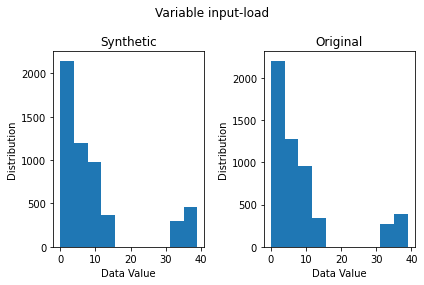

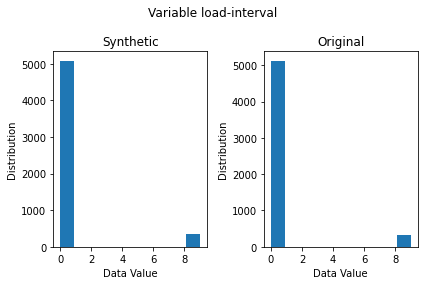

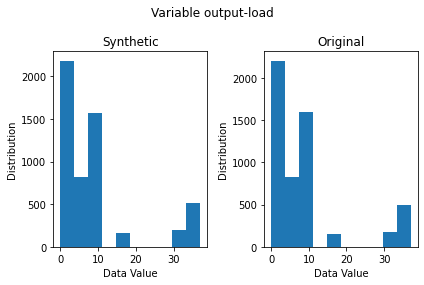

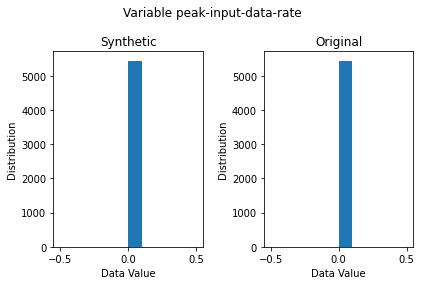

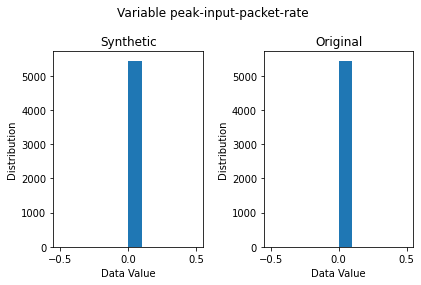

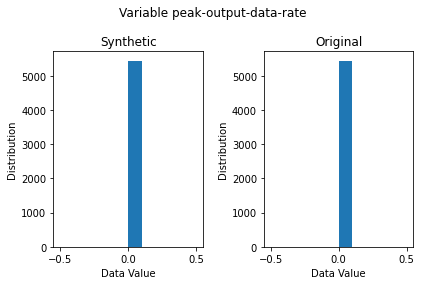

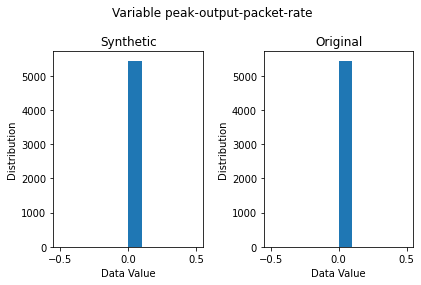

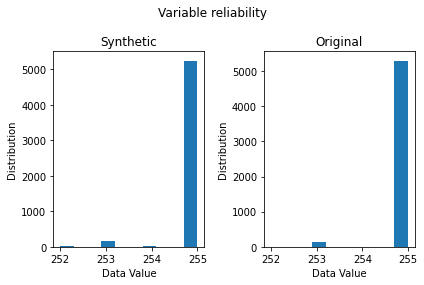

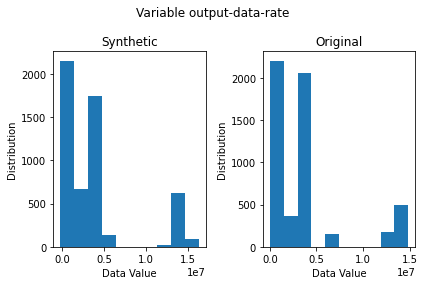

In [45]:

plot_variable_distributions(
    categorical_columns=original_categorical_columns,
    continuous_columns=original_continuous_columns,
    data_supp=original_X_test,
    synthetic_supp=test_synthetic_supp,
    saving_filepath="figs/",
    pre_proc_method=pre_proc_method,
)


# Accuracy Metric Evaluation

We use the SDV evaluation framework. Supply the metrics you wish to find in the distributional_metrics list from SDV guidance. Can start here: https://sdv.dev/SDV/user_guides/evaluation/single_table_metrics.html

In [55]:
pd.set_option("display.precision", 7)
original_X_test.mean()

input-data-rate            3.4163279e+06
input-load                 8.4050679e+00
input-packet-rate          2.2304281e+05
load-interval              5.2056555e-01
output-data-rate           3.4047365e+06
output-load                8.3319868e+00
output-packet-rate         2.9475370e+05
peak-input-data-rate       0.0000000e+00
peak-input-packet-rate     0.0000000e+00
peak-output-data-rate      0.0000000e+00
peak-output-packet-rate    0.0000000e+00
reliability                2.5494638e+02
dtype: float64

In [50]:
test_synthetic_supp.quantile(0.99)

input-data-rate            1.5577246e+07
input-load                 3.9000000e+01
input-packet-rate          1.0745365e+06
load-interval              9.0000000e+00
output-data-rate           1.4812489e+07
output-load                3.7000000e+01
output-packet-rate         1.2951920e+06
peak-input-data-rate       0.0000000e+00
peak-input-packet-rate     0.0000000e+00
peak-output-data-rate      0.0000000e+00
peak-output-packet-rate    0.0000000e+00
reliability                2.5500000e+02
Name: 0.99, dtype: float64

In [51]:
original_X_test.quantile(0.99)

input-data-rate            15504559.1
input-load                       39.0
input-packet-rate           1066056.8
load-interval                     9.0
output-data-rate           14793546.9
output-load                      37.0
output-packet-rate          1281788.2
peak-input-data-rate              0.0
peak-input-packet-rate            0.0
peak-output-data-rate             0.0
peak-output-packet-rate           0.0
reliability                     255.0
Name: 0.99, dtype: float64

In [ ]:
# vae_generation_diff_list = input_df.quantile(0.9) - synthetic_supp.quantile(0.9)
# noise_diff_list = input_df.quantile(0.9) - noisy_tmp_df.quantile(0.9)

vae_generation_diff_list = input_df.mean() - synthetic_supp.mean()
noise_diff_list = input_df.mean() - noisy_tmp_df.mean()
vae_generation_diff_list
# noise_diff_list

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
x1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x, vae_generation_diff_list, width=0.4, color='blue', label='VAE output Y compared with X')
ax.bar(x1, noise_diff_list, width=0.4, color='orange', label='X+noise compared with X')

plt.legend()
plt.ylabel('Real - Synthetic')
plt.xlabel( 'Different dimension of telemetry data' )
plt.title('Mean value')
plt.show

In [ ]:
distributional_metrics = [
    "KSTest",
    "ContinuousKLDivergence",
    "DiscreteKLDivergence",
]

gower = False

metrics = distribution_metrics(
    gower_bool=gower,
    distributional_metrics=distributional_metrics,
    data_supp=input_df,
    synthetic_supp=synthetic_supp,
    categorical_columns=original_categorical_columns,
    continuous_columns=original_continuous_columns,
    saving_filepath=None,
    pre_proc_method=pre_proc_method,
)
metrics

In [ ]:
manual_noise_metrics = distribution_metrics(
    gower_bool=gower,
    distributional_metrics=distributional_metrics,
    data_supp=input_df,
    synthetic_supp=noisy_tmp_df,
    categorical_columns=original_categorical_columns,
    continuous_columns=original_continuous_columns,
    saving_filepath=None,
    pre_proc_method=pre_proc_method,
)
manual_noise_metrics

# Privacy Metric Evaluation

Using SDV privacy metrics we can get an insight into how privacy is conserved when utilising dp-sgd methods. SDV's privacy metrics are limited in that they can only be used on similar data types. E.g. if we choose age to be the sensitive variably, we can build ML based models to predict a users age using the other columns. However we are forced to only use columns that are also continuous variables.

In [79]:
# Specify our private variable

private_variable = "input-data-rate"

privacy_metric = privacy_metrics(
    private_variable=private_variable,
    data_supp=original_X_test,
    synthetic_supp=test_synthetic_supp,
    categorical_columns=original_categorical_columns,
    continuous_columns=original_continuous_columns
)

privacy_metric

0.018421907815181434

In [69]:
all_data = torch.tensor(original_X_test.to_numpy())

# Define the privacy budget
privacy_budget = 1e-4

# Calculate the sensitivity of the function (maximum difference between two adjacent datasets)
sensitivity = torch.max(torch.abs(all_data - (all_data + torch.ones_like(all_data))) )

# Calculate delta (probability of the function output deviating from the true output by more than epsilon)
delta = 1 / len(all_data)

# Calculate the epsilon value
epsilon = privacy_budget / delta

# Check if the privacy guarantee is satisfied
if epsilon <= sensitivity / noise_scale:
    print("The function satisfies differential privacy with epsilon = ", epsilon)
else:
    print("The function does not satisfy differential privacy with epsilon = ", epsilon)


The function satisfies differential privacy with epsilon =  0.5446000000000001


In [60]:
# A is original, B is new generated data
# Compare each data point to calculate the epsilon
epsilon = 1.0
A = original_X_test['input-load'].tolist()
B = test_synthetic_supp['input-load'].tolist()
# print(B)
probabilities = []
for i in range(len(A)):
    prob = np.exp(epsilon * np.abs(B[i] - A[i])) / 2.0 / noise_scale
    probabilities.append(prob)
epsilon_actual = np.mean(probabilities)

# Print the epsilon value
print("Actual Epsilon:", epsilon_actual)

Actual Epsilon: 5945093545126779.0
